In [1]:
import geopandas
from shapely import geometry
import matplotlib.pyplot as plt
from scipy.spatial import (
    Voronoi,
    voronoi_plot_2d,
    Delaunay,
    delaunay_plot_2d,
    cKDTree
)
from sklearn.model_selection import train_test_split
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import math, time
import interpolators

plt.rcParams['figure.figsize'] = 15, 10

external_crs = "EPSG:4326"
internal_crs = "EPSG:3068"
berlin_districts = geopandas.read_file("../shared/berlinDistricts.geojson")
measurements = geopandas.read_file("meeting-test/data_2020-03-02T14-00-00.geojson")

berlin_districts = berlin_districts.to_crs(internal_crs)
measurements = measurements.to_crs(internal_crs)

x = np.array(measurements.geometry.x)
y = np.array(measurements.geometry.y)
values = np.array(measurements.value)
points = np.column_stack((x, y))

xmin, ymin, xmax, ymax = measurements.total_bounds
size = 500  # grid cell size in meters
xnew = np.linspace(xmin, xmax, int((xmax - xmin) / size))
ynew = np.linspace(ymin, ymax, int((ymax - ymin) / size))
zones = [0, 20, 40, 100, 200, 400]



In [ ]:
# Cross validation

points_train, points_test, values_train, values_test = train_test_split(points, values, test_size=0.2)

interpolation_method = interpolators.nearest_neighbor
interpolated_values = interpolation_method(points_test[:,0], points_test[:,1], points_train, values_train, grid=False)

print(mean_squared_error(values_test, interpolated_values))
plt.scatter(values_test, interpolated_values)
plt.plot([0, np.max(values_test)], [0, np.max(values_test)])

Interpolation method: discrete_natural_neighbor -> 0.5077087879180908
Interpolation method: metpy_natural_neighbor -> 99.26549243927002
Interpolation method: scipy_natural_neighbor -> 1006.029049873352


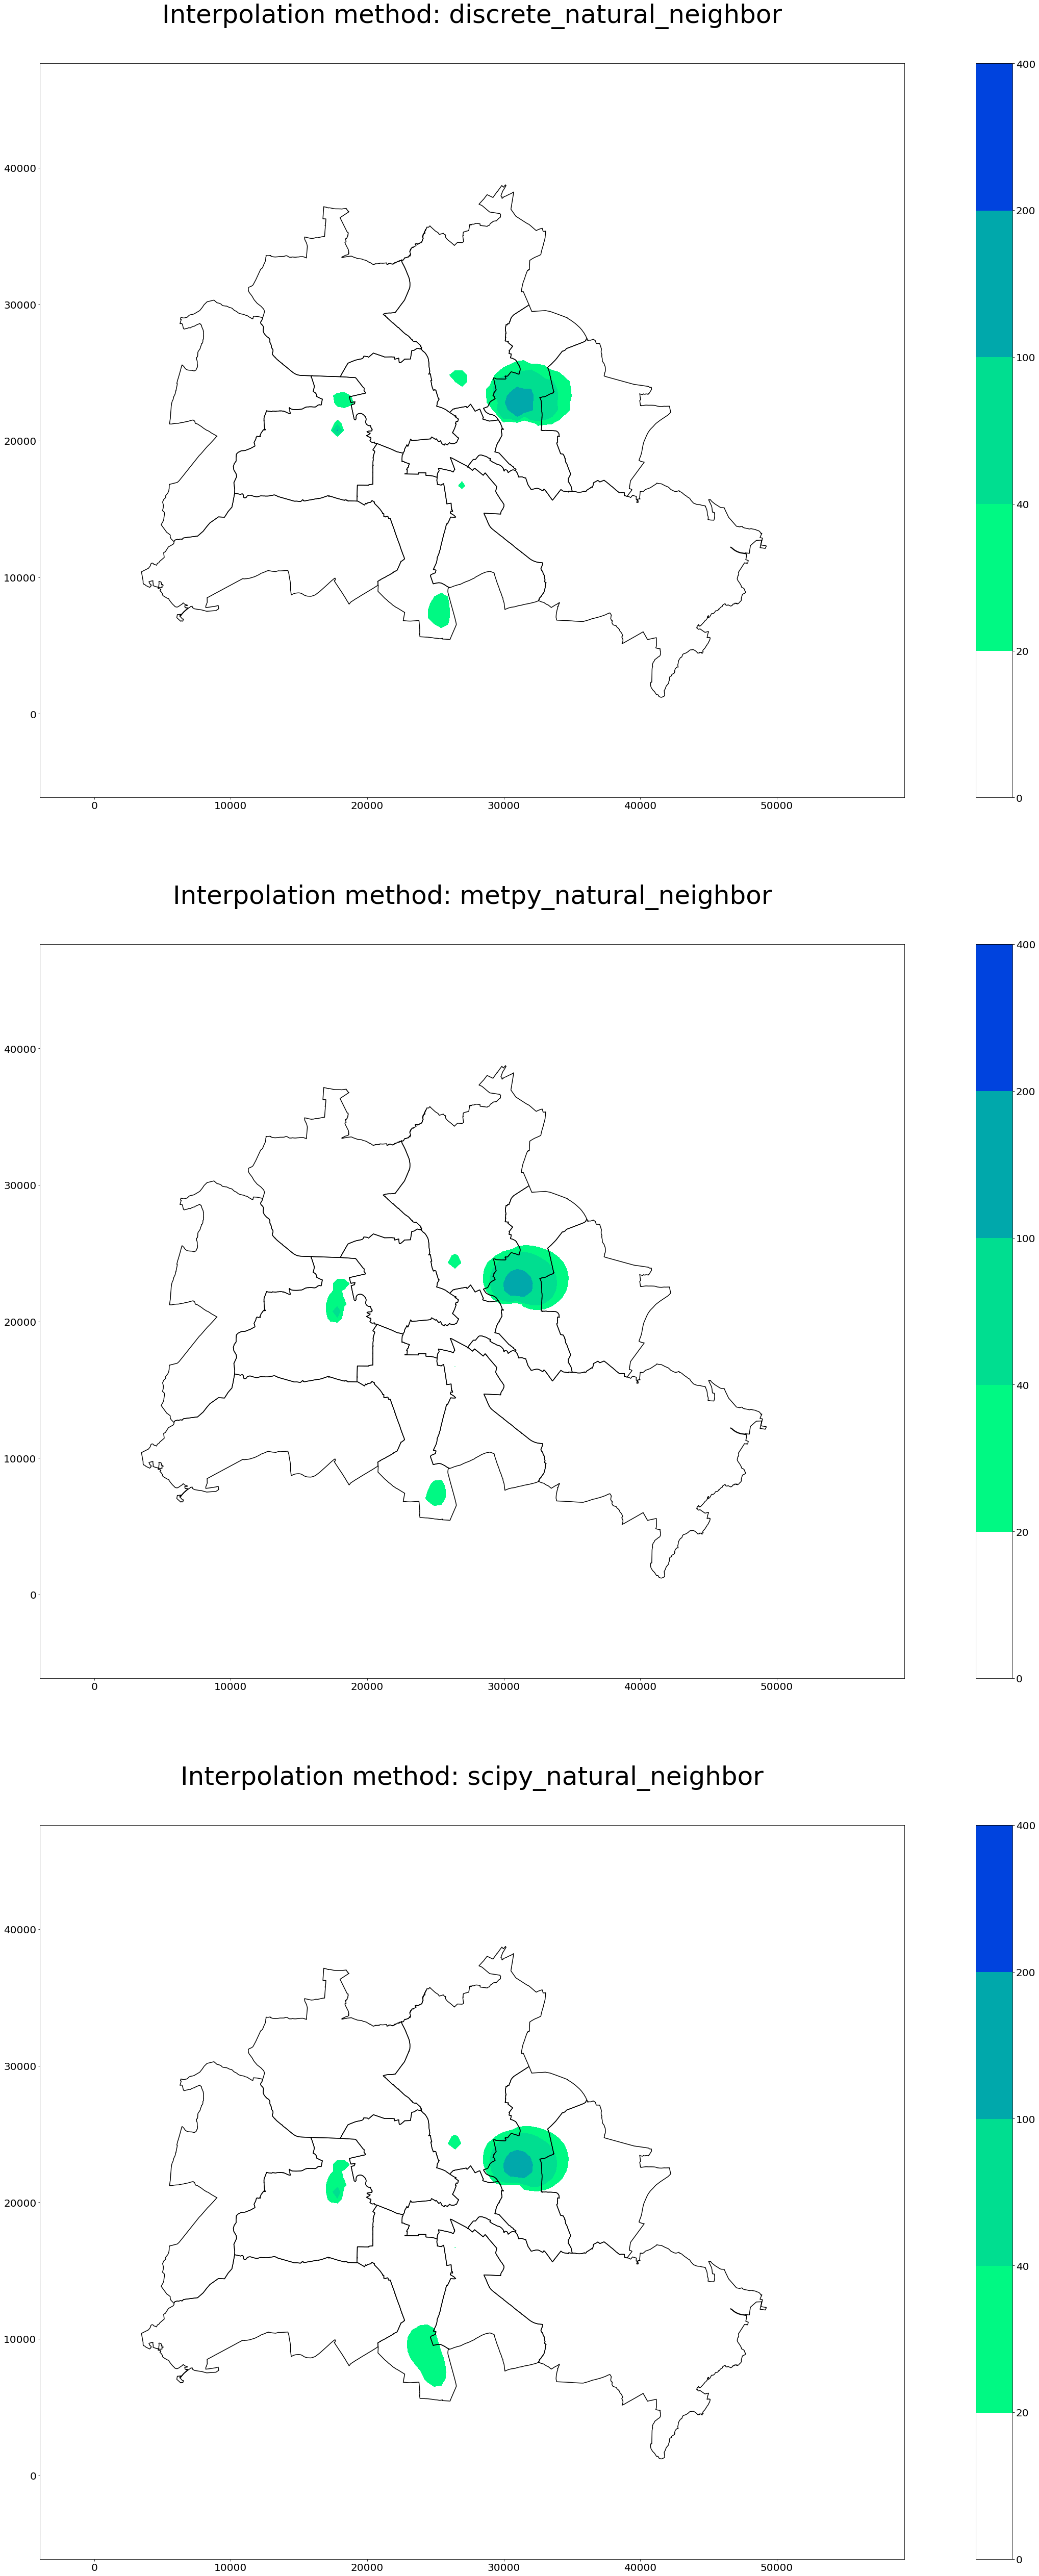

In [2]:
# Method comparison
methods = {
    "discrete_natural_neighbor": interpolators.discrete_natural_neighbor,
    "metpy_natural_neighbor": interpolators.metpy_natural_neighbor,
    "scipy_natural_neighbor": interpolators.scipy_natural_neighbor
}

plt.rcParams["figure.figsize"] = 50, len(methods) * 30
plt.rcParams["font.size"] = 20
plt.rcParams["axes.titlesize"] = 50
plt.rcParams["axes.titlepad"] = 80

size = 500  # grid cell size in meters
xnew = np.linspace(xmin, xmax, int((xmax - xmin) / size))
ynew = np.linspace(ymin, ymax, int((ymax - ymin) / size))

fig, axes = plt.subplots(len(methods),1)

for i, ax in enumerate(axes):
    berlin_districts.boundary.plot(ax=ax, edgecolor="black")
    ax.set_title(f"Interpolation method: {list(methods.keys())[i]}")
    start = time.time()
    interpolated_values = list(methods.values())[i](xnew, ynew, points, values)
    end = time.time()
    plot = ax.contourf(xnew, ynew, interpolated_values, zones, cmap="winter_r")
    plot.cmap.set_under("w")
    plot.set_clim(zones[1])
    fig.colorbar(plot, ax=ax)
    print(f"Interpolation method: {list(methods.keys())[i]} -> {end-start}")

fig.savefig("natural-neighbor-comparison.png")

Grid cell size = 5000m -> 0.015986919403076172
Grid cell size = 1000m -> 0.18089532852172852
Grid cell size = 500m -> 0.6944801807403564
Grid cell size = 300m -> 1.7112390995025635
Grid cell size = 100m -> 27.870972633361816


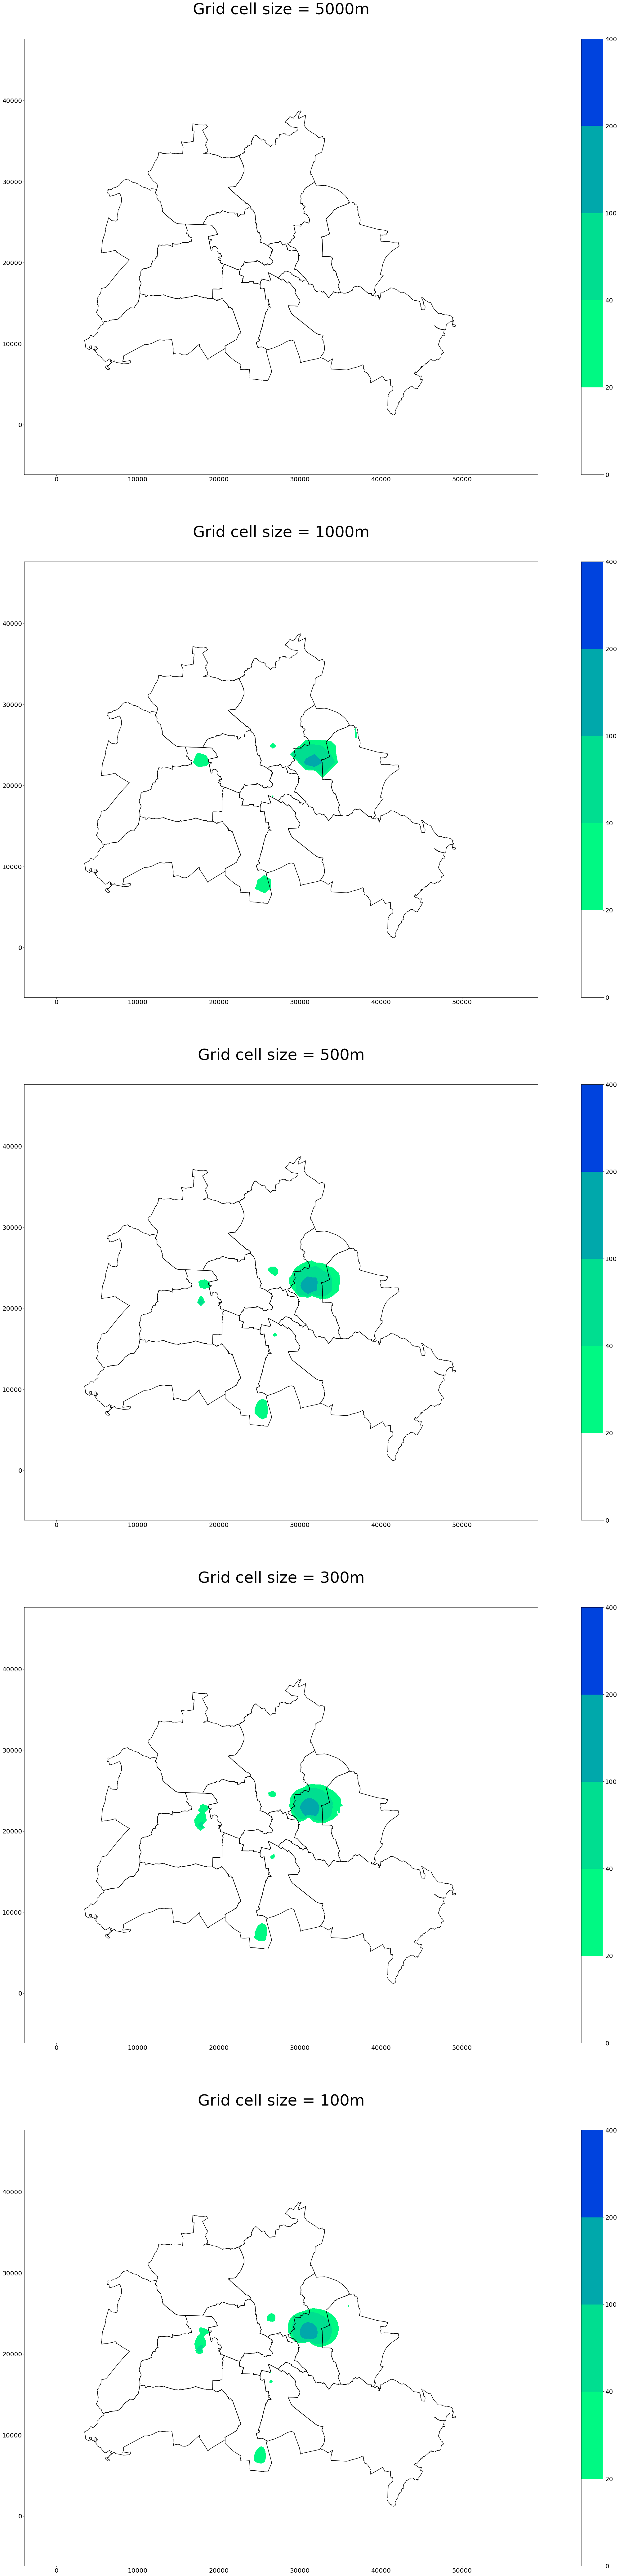

In [2]:
# Grid comparison

interpolation_method = interpolators.discrete_natural_neighbor

# cell_sizes = [5000, 1000, 500, 300, 100, 50, 10]
cell_sizes = [5000, 1000, 500, 300, 100]

plt.rcParams["figure.figsize"] = 50, len(cell_sizes) * 30
plt.rcParams["font.size"] = 20
plt.rcParams["axes.titlesize"] = 50
plt.rcParams["axes.titlepad"] = 80

fig, axes = plt.subplots(len(cell_sizes),1)

for i, ax in enumerate(axes):
    berlin_districts.boundary.plot(ax=ax, edgecolor="black")
    size = cell_sizes[i]  # grid cell size in meters
    xnew = np.linspace(xmin, xmax, int((xmax - xmin) / size))
    ynew = np.linspace(ymin, ymax, int((ymax - ymin) / size))
    ax.set_title(f"Grid cell size = {size}m")
    start = time.time()
    interpolated_values = interpolation_method(xnew, ynew, points, values)
    end = time.time()
    plot = ax.contourf(xnew, ynew, interpolated_values, zones, cmap="winter_r")
    plot.cmap.set_under("w")
    plot.set_clim(zones[1])
    fig.colorbar(plot, ax=ax)
    print(f"Grid cell size = {size}m -> {end-start}")

fig.savefig(f"grid-comparison-{interpolation_method.__name__}.png")